# Loading the datasest using Kaggle API

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jasonfm26/bigfile

 73% 49.0M/67.1M [00:00<00:00, 145MB/s] 
100% 67.1M/67.1M [00:00<00:00, 144MB/s]


In [ ]:
!unzip /content/bigfile.zip

Archive:  /content/bigfile.zip
  inflating: 1024 x 1024/test/caries/wc1.jpg  
  inflating: 1024 x 1024/test/caries/wc1_0.jpg  
  inflating: 1024 x 1024/test/caries/wc1_1.jpg  
  inflating: 1024 x 1024/test/caries/wc1_10.jpg  
  inflating: 1024 x 1024/test/caries/wc1_11.jpg  
  inflating: 1024 x 1024/test/caries/wc1_12.jpg  
  inflating: 1024 x 1024/test/caries/wc1_13.jpg  
  inflating: 1024 x 1024/test/caries/wc1_14.jpg  
  inflating: 1024 x 1024/test/caries/wc1_15.jpg  
  inflating: 1024 x 1024/test/caries/wc1_16.jpg  
  inflating: 1024 x 1024/test/caries/wc1_17.jpg  
  inflating: 1024 x 1024/test/caries/wc1_18.jpg  
  inflating: 1024 x 1024/test/caries/wc1_19.jpg  
  inflating: 1024 x 1024/test/caries/wc1_2.jpg  
  inflating: 1024 x 1024/test/caries/wc1_3.jpg  
  inflating: 1024 x 1024/test/caries/wc1_4.jpg  
  inflating: 1024 x 1024/test/caries/wc1_5.jpg  
  inflating: 1024 x 1024/test/caries/wc1_6.jpg  
  inflating: 1024 x 1024/test/caries/wc1_7.jpg  
  inflating: 1024 x 1024/test/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
train_path = "/content/1024 x 1024/train/"
test_path = "/content/1024 x 1024/test"

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.utils.vis_utils import plot_model
from glob import glob

## Getting contents of training data

In [ ]:
x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 315/315 [00:07<00:00, 41.45it/s]


In [ ]:
data.shape

(1260, 2)

In [ ]:
from collections import Counter
Counter(y_data)

Counter({'caries': 945, 'no-caries': 315})

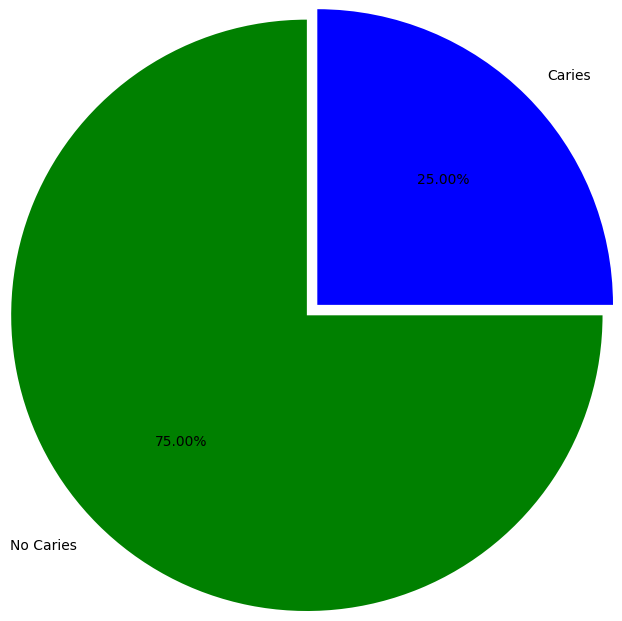

In [ ]:
colors = ['green','blue']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',labels=['No Caries', 'Caries'], colors= colors,radius=2)
plt.show()

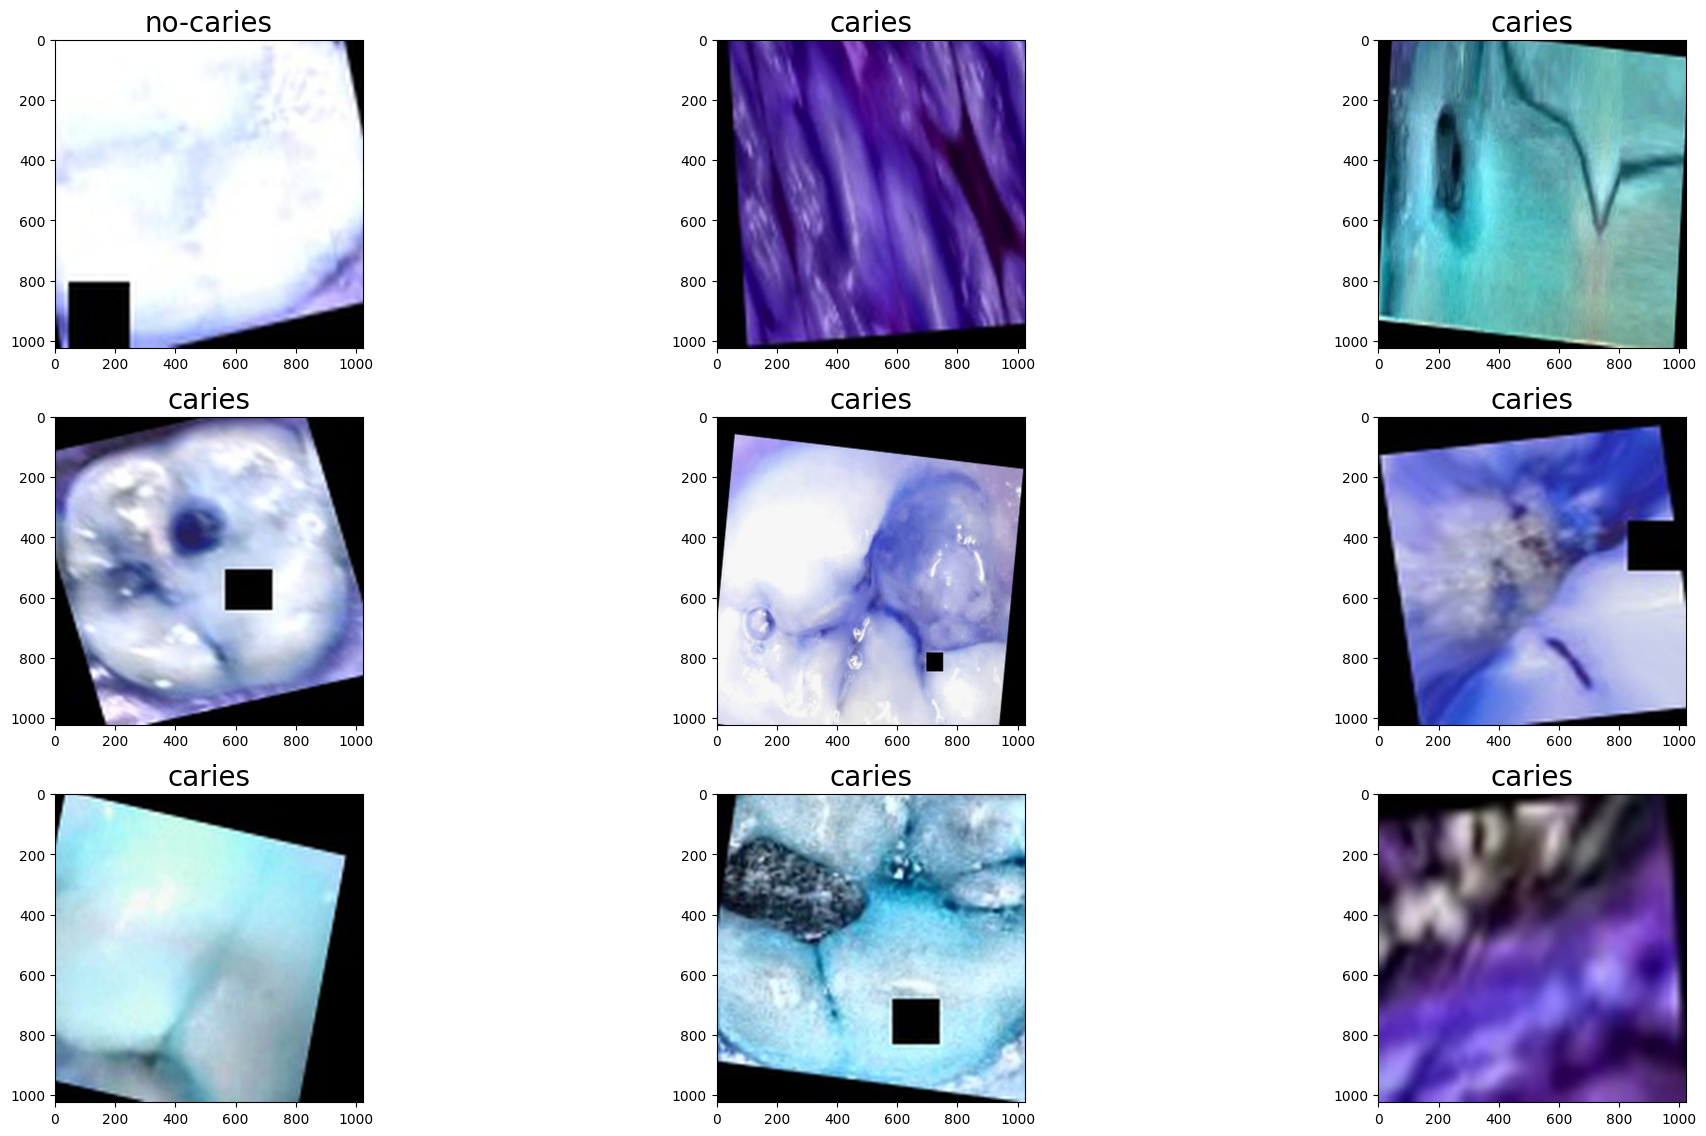

In [ ]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(1000)
    plt.title('{0}'.format(data.label[index]),fontdict={'size':20})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


## Getting contents of testing data

In [ ]:
x_data = []
y_data = []

for category in glob(test_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 84/84 [00:00<00:00, 94.68it/s]


In [ ]:
data.shape

(294, 2)

In [ ]:
from collections import Counter
Counter(y_data)

Counter({'caries': 210, 'no-caries': 84})

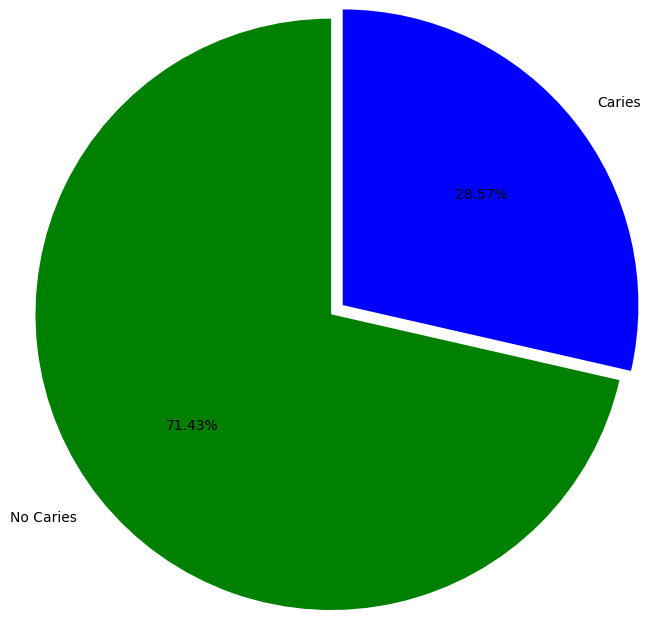

In [ ]:
colors = ['green','blue']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',labels=['No Caries', 'Caries'], colors= colors,radius=2)
plt.show()

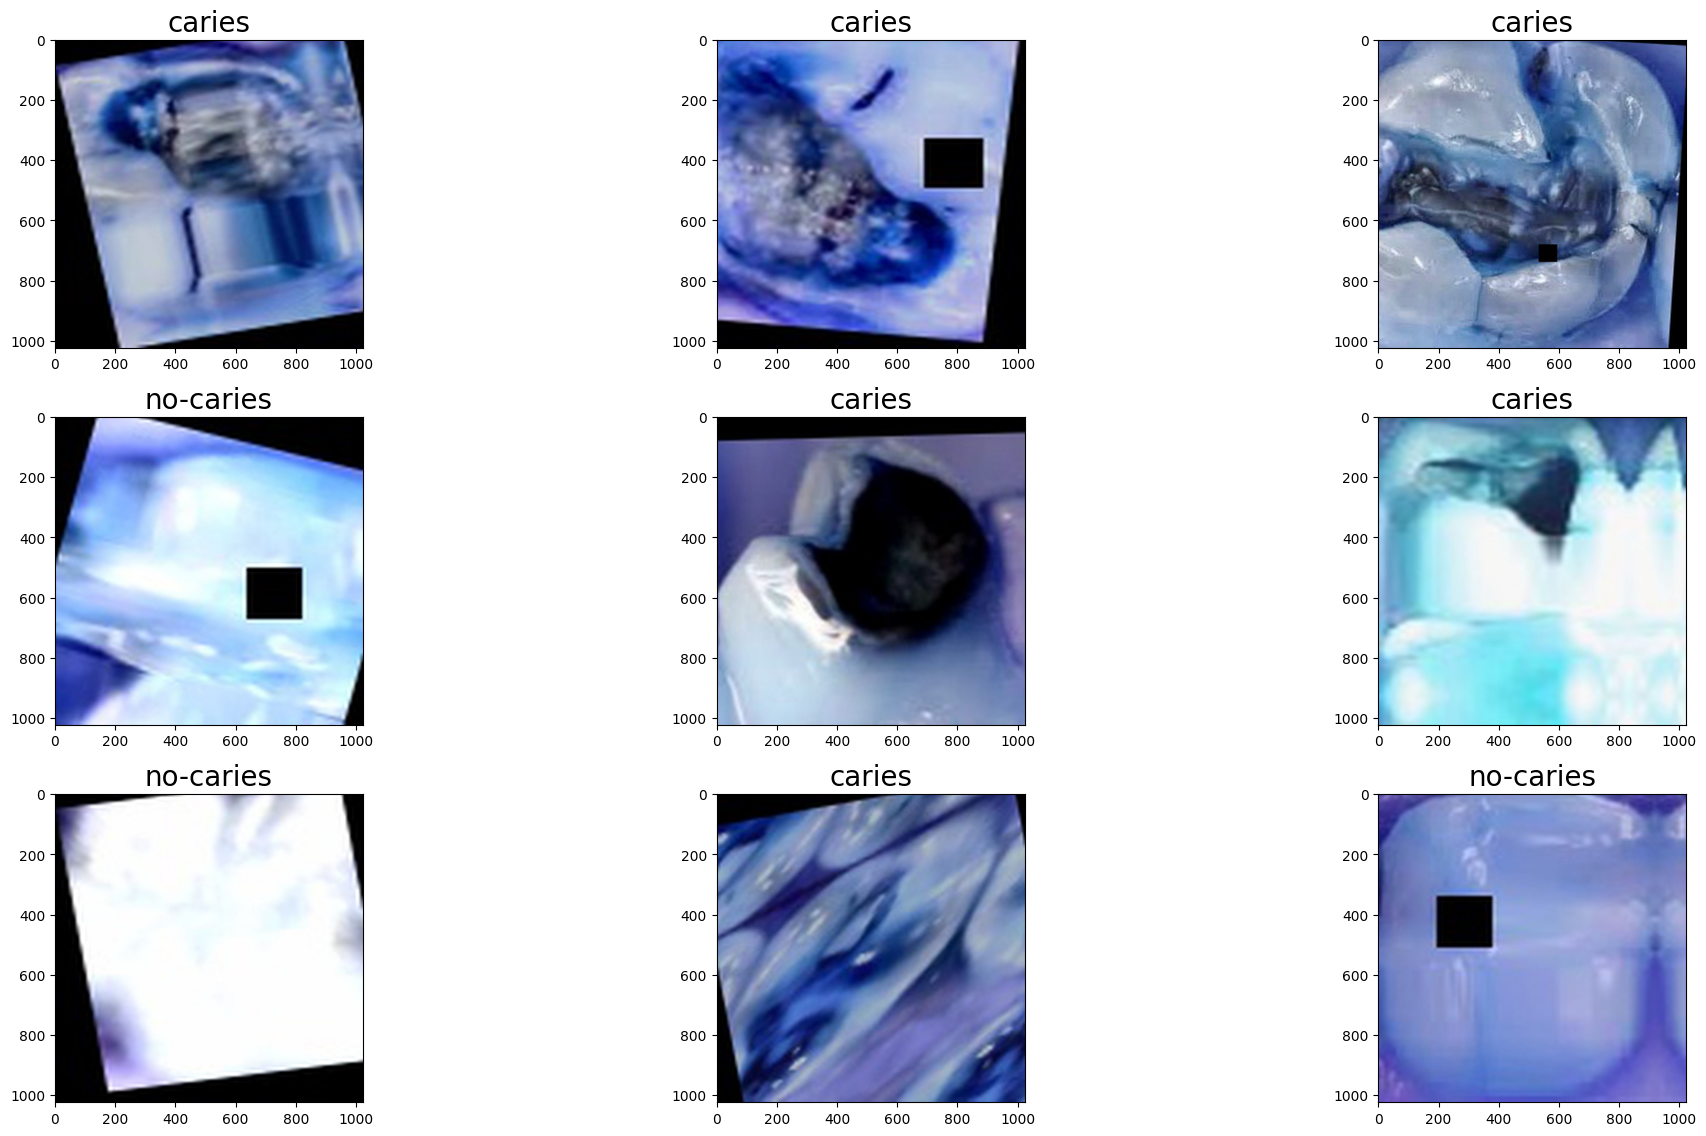

In [ ]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(294)
    plt.title('{0}'.format(data.label[index]),fontdict={'size':20})
    plt.imshow(data.image[index])
    plt.tight_layout()

# Model Building

## Image Augmentation

In [ ]:
train_generator = ImageDataGenerator(
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
test_generator = ImageDataGenerator(rescale=1./255.)


In [ ]:
train_datagen = train_generator.flow_from_directory(
    train_path,
    batch_size=10,
    target_size=(224, 224)
)
test_datagen = test_generator.flow_from_directory(
    test_path,
    batch_size=10,
    target_size=(224, 224)
)

Found 1260 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


## Proposed CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

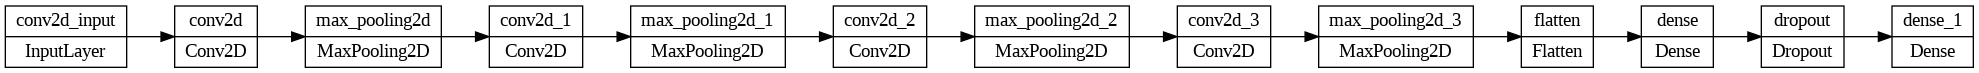

In [ ]:
plot_model(model, rankdir = "LR")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
hist_cnn = model.fit_generator(generator = train_datagen,epochs=20,validation_data = test_datagen)

Epoch 1/20
126/126 [==============================] - 48s 289ms/step - loss: 0.6003 - accuracy: 0.7460 - val_loss: 0.5380 - val_accuracy: 0.7143
Epoch 2/20
126/126 [==============================] - 37s 291ms/step - loss: 0.5614 - accuracy: 0.7500 - val_loss: 0.5893 - val_accuracy: 0.7143
Epoch 3/20
126/126 [==============================] - 35s 278ms/step - loss: 0.5430 - accuracy: 0.7556 - val_loss: 0.5149 - val_accuracy: 0.7143
Epoch 4/20
126/126 [==============================] - 36s 287ms/step - loss: 0.5348 - accuracy: 0.7508 - val_loss: 0.4063 - val_accuracy: 0.7245
Epoch 5/20
126/126 [==============================] - 36s 284ms/step - loss: 0.5064 - accuracy: 0.7643 - val_loss: 0.4159 - val_accuracy: 0.7347
Epoch 6/20
126/126 [==============================] - 34s 272ms/step - loss: 0.4967 - accuracy: 0.7667 - val_loss: 0.3874 - val_accuracy: 0.7789
Epoch 7/20
126/126 [==============================] - 35s 280ms/step - loss: 0.4645 - accuracy: 0.7770 - val_loss: 0.4743 - val_ac

## Transfer Learning

### ResNet50

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_res = Model(inputs=base_model.input, outputs=predictions)

model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_res = model_res.fit(train_datagen, epochs=25, validation_data=test_datagen)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/25
126/126 [==============================] - 44s 302ms/step - loss: 0.8180 - accuracy: 0.6175 - val_loss: 0.6297 - val_accuracy: 0.7143
Epoch 2/25
126/126 [==============================] - 36s 284ms/step - loss: 0.7002 - accuracy: 0.6849 - val_loss: 0.7878 - val_accuracy: 0.7143
Epoch 3/25
126/126 [==============================] - 35s 282ms/step - loss: 0.6377 - accuracy: 0.7008 - val_loss: 0.5544 - val_accuracy: 0.7143
Epoch 4/25
126/126 [==============================] - 36s 282ms/step - loss: 0.6109 - accuracy: 0.7317 - val_loss: 0.6150 - val_accuracy: 0.7143
Epoch 5/25
126/126 [==============================] - 36s 283ms/step - loss: 0.5955 - accuracy: 0.7198 - val_loss: 0.8478 - val_accuracy: 0.7143
Epoch 6/25
126/126 [==============================] - 37s 295ms/step - loss: 0.5687 - accuracy: 0.7317 - val_loss: 0.4728 - val_accuracy: 0.7687
Epoch 7/25
126/126 [==============================] - 36s 284ms/s

### InceptionV3

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_inc = Model(inputs=base_model.input, outputs=predictions)

model_inc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_inc = model_inc.fit(train_datagen, epochs=10, validation_data=test_datagen)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/10
126/126 [==============================] - 45s 296ms/step - loss: 0.7905 - accuracy: 0.6611 - val_loss: 0.4442 - val_accuracy: 0.7959
Epoch 2/10
126/126 [==============================] - 35s 280ms/step - loss: 0.5820 - accuracy: 0.7579 - val_loss: 0.4940 - val_accuracy: 0.7721
Epoch 3/10
126/126 [==============================] - 35s 281ms/step - loss: 0.4771 - accuracy: 0.8111 - val_loss: 0.4042 - val_accuracy: 0.8129
Epoch 4/10
126/126 [==============================] - 35s 280ms/step - loss: 0.4694 - accuracy: 0.7968 - val_loss: 0.4165 - val_accuracy: 0.7789
Epoch 5/10
126/126 [==============================] - 35s 279ms/step - loss: 0.4279 - accuracy: 0.8190 - val_loss: 0.4488 - val_accuracy: 0.7517
Epoch 6/10
126/126 [==============================] - 37s 289ms/step - loss: 0.4121 - accuracy: 0.8175 - val_loss: 0.3673 - val_accuracy: 0.8095
Epoch 7/10
126/126 [==============================] - 35s 279ms/s

### MobileNetV2

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_mob = Model(inputs=base_model.input, outputs=predictions)

model_mob.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_mob = model_mob.fit(train_datagen, epochs=20, validation_data=test_datagen)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
126/126 [==============================] - 41s 279ms/step - loss: 0.7767 - accuracy: 0.6627 - val_loss: 0.4138 - val_accuracy: 0.7959
Epoch 2/20
126/126 [==============================] - 34s 269ms/step - loss: 0.5815 - accuracy: 0.7627 - val_loss: 0.3357 - val_accuracy: 0.8537
Epoch 3/20
126/126 [==============================] - 34s 268ms/step - loss: 0.4698 - accuracy: 0.7984 - val_loss: 0.3747 - val_accuracy: 0.8469
Epoch 4/20
126/126 [==============================] - 34s 270ms/step - loss: 0.4339 - accuracy: 0.8214 - val_loss: 0.3726 - val_accuracy: 0.8469
Epoch 5/20
126/126 [==============================] - 34s 270ms/step - loss: 0.3836 - accuracy: 0.8452 - val_loss: 0.3449 - val_accuracy: 0.8605
Epoch 6/20
126/126 [==============================] - 34s 267ms/step - loss: 0.3766 - accuracy: 0.8325 - val_loss: 0.3247 - val_accuracy: 0.8741
Epoch 7/20
126/126 [==============================] - 34s 266ms/ste

### VGG16

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_vgg = model_vgg.fit(train_datagen, epochs=20, validation_data=test_datagen)

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/20
126/126 [==============================] - 43s 302ms/step - loss: 0.7632 - accuracy: 0.6857 - val_loss: 0.5936 - val_accuracy: 0.7143
Epoch 2/20
126/126 [==============================] - 37s 293ms/step - loss: 0.5409 - accuracy: 0.7762 - val_loss: 0.6818 - val_accuracy: 0.7143
Epoch 3/20
126/126 [==============================] - 37s 294ms/step - loss: 0.4711 - accuracy: 0.8071 - val_loss: 0.5040 - val_accuracy: 0.7517
Epoch 4/20
126/126 [==============================] - 37s 291ms/step - loss: 0.4494 - accuracy: 0.7968 - val_loss: 0.4420 - val_accuracy: 0.8027
Epoch 5/20
126/126 [==============================] - 37s 296ms/step - loss: 0.4295 - accuracy: 0.8175 - val_loss: 0.5116 - val_accuracy: 0.7653
Epoch 6/20
126/126 [==============================] - 37s 290ms/step - loss: 0.4013 - accuracy: 0.8381 - val_loss: 0.3963 - val_accuracy: 0.8231
Epoch 7/20
126/126 [==============================] - 37s 291ms/s

# **Model Evaluation**

In [ ]:
# Creating holders to store the model performance results
Deep_Learning_Model = []
Training_accuracy = []
Validation_accuracy = []
Training_loss = []
Validation_loss = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
  Deep_Learning_Model.append(model)
  Training_accuracy.append(round(a, 3))
  Validation_accuracy.append(round(b, 3))
  Training_loss.append(round(c, 3))
  Validation_loss.append(round(d, 3))

# Proposed CNN Model

### Accuracy Curve

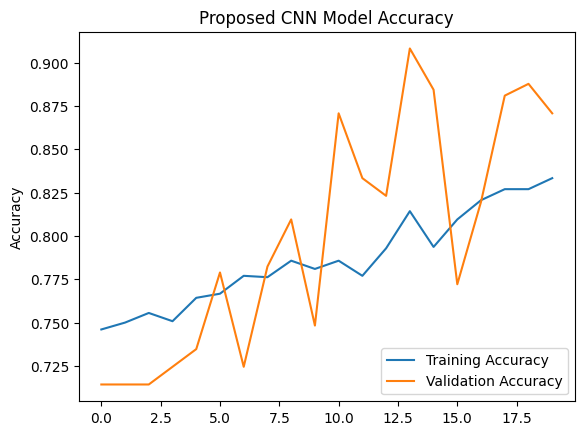

In [ ]:
acc = hist_cnn.history['accuracy']
val_acc = hist_cnn.history['val_accuracy']

acc1 = hist_cnn.history['accuracy'][-1]
val_acc1 = hist_cnn.history['val_accuracy'][-1]

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Proposed CNN Model Accuracy')
plt.show()

### Loss Curve

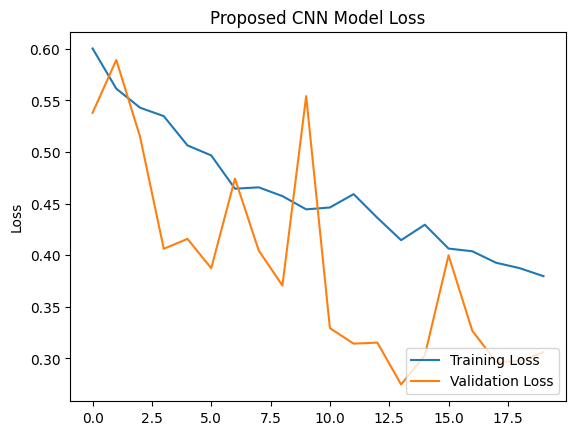

In [ ]:
loss = hist_cnn.history['loss']
val_loss = hist_cnn.history['val_loss']

loss1 = hist_cnn.history['loss'][-1]
val_loss1 = hist_cnn.history['val_loss'][-1]

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Proposed CNN Model Loss')
plt.show()

#storing the results. The below mentioned order of parameter passing is important.

storeResults('Proposed CNN Model',acc1,val_acc1,
             loss1,val_loss1)

# ResNet50

### Accuracy Curve

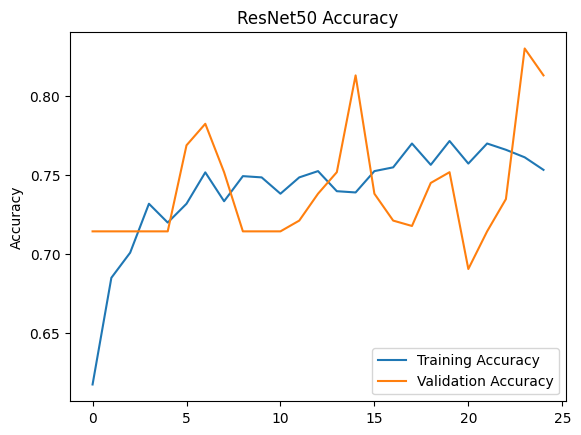

In [ ]:
acc = hist_res.history['accuracy']
val_acc = hist_res.history['val_accuracy']

acc1 = hist_res.history['accuracy'][-1]
val_acc1 = hist_res.history['val_accuracy'][-1]

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('ResNet50 Accuracy')
plt.show()



### Loss Curve

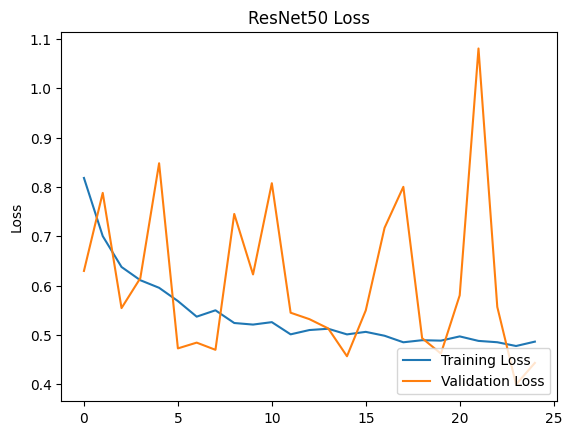

In [ ]:
loss = hist_res.history['loss']
val_loss = hist_res.history['val_loss']

loss1 = hist_res.history['loss'][-1]
val_loss1 = hist_res.history['val_loss'][-1]

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('ResNet50 Loss')
plt.show()

#storing the results. The below mentioned order of parameter passing is important.

storeResults('ResNet50',acc1,val_acc1,
             loss1,val_loss1)

# InceptionV3

### Accuracy Curve

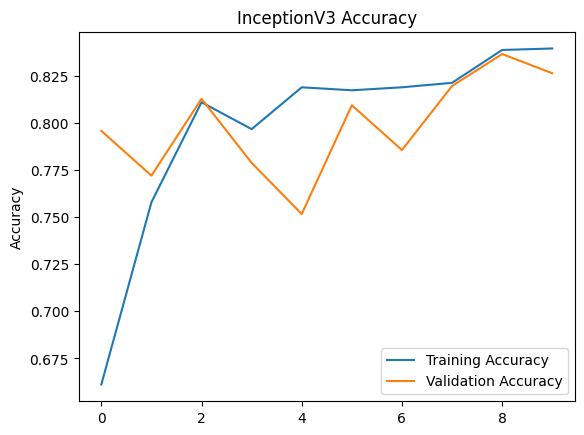

In [ ]:
acc = hist_inc.history['accuracy']
val_acc = hist_inc.history['val_accuracy']

acc1 = hist_inc.history['accuracy'][-1]
val_acc1 = hist_inc.history['val_accuracy'][-1]

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('InceptionV3 Accuracy')
plt.show()

### Loss Curve

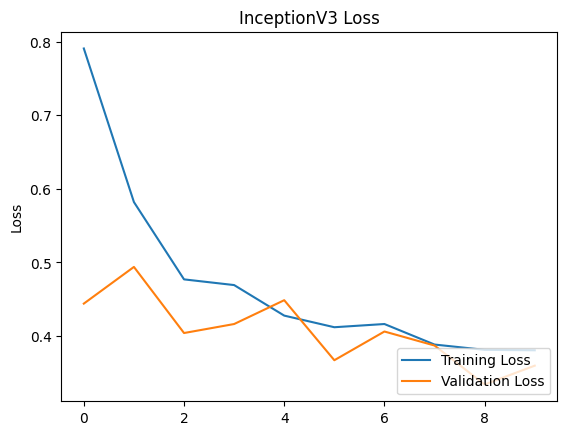

In [ ]:
loss = hist_inc.history['loss']
val_loss = hist_inc.history['val_loss']

loss1 = hist_inc.history['loss'][-1]
val_loss1 = hist_inc.history['val_loss'][-1]

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('InceptionV3 Loss')
plt.show()

#storing the results. The below mentioned order of parameter passing is important.

storeResults('InceptionV3',acc1,val_acc1,
             loss1,val_loss1)

# MobileNetV2

### Accuracy Curve

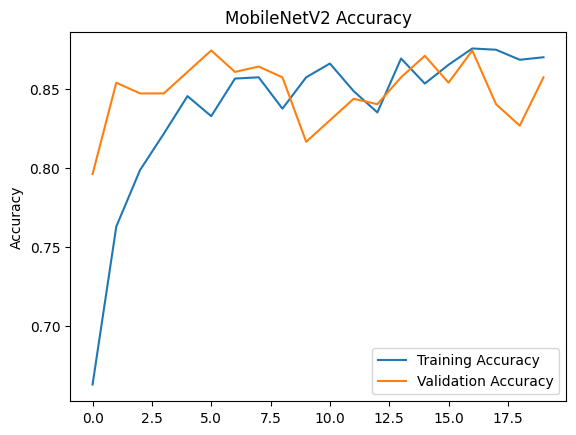

In [ ]:
acc = hist_mob.history['accuracy']
val_acc = hist_mob.history['val_accuracy']

acc1 = hist_mob.history['accuracy'][-1]
val_acc1 = hist_mob.history['val_accuracy'][-1]

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('MobileNetV2 Accuracy')
plt.show()

### Loss Curve

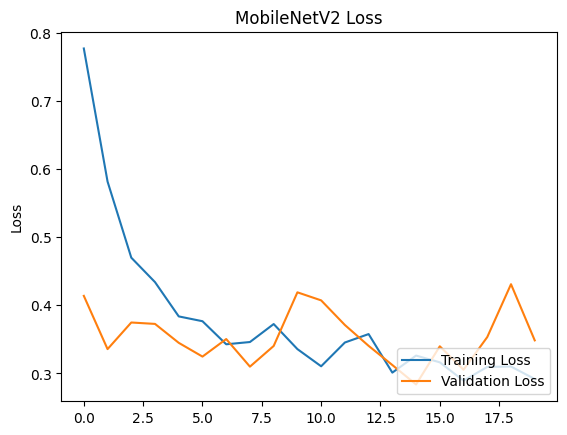

In [ ]:
loss = hist_mob.history['loss']
val_loss = hist_mob.history['val_loss']

loss1 = hist_mob.history['loss'][-1]
val_loss1 = hist_mob.history['val_loss'][-1]

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('MobileNetV2 Loss')
plt.show()

#storing the results. The below mentioned order of parameter passing is important.

storeResults('MobileNetV2',acc1,val_acc1,
             loss1,val_loss1)

# VGG16

### Accuracy Curve

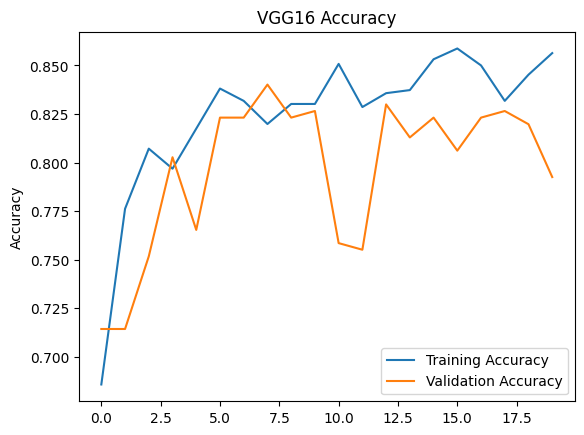

In [ ]:
acc = hist_vgg.history['accuracy']
val_acc = hist_vgg.history['val_accuracy']

acc1 = hist_vgg.history['accuracy'][-1]
val_acc1 = hist_vgg.history['val_accuracy'][-1]

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('VGG16 Accuracy')
plt.show()

### Loss Curve

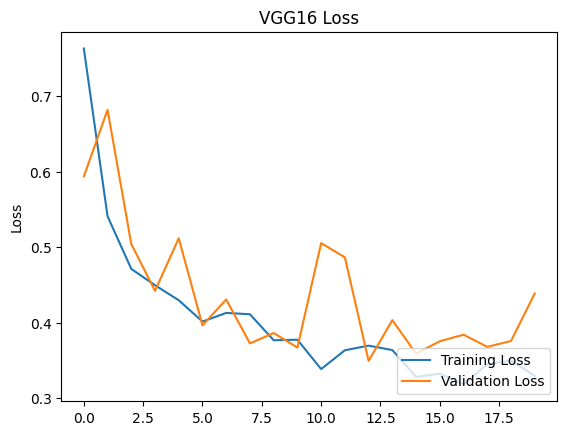

In [ ]:
loss = hist_vgg.history['loss']
val_loss = hist_vgg.history['val_loss']

loss1 = hist_vgg.history['loss'][-1]
val_loss1 = hist_vgg.history['val_loss'][-1]

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('VGG16 Loss')
plt.show()

#storing the results. The below mentioned order of parameter passing is important.

storeResults('VGG16',acc1,val_acc1,
             loss1,val_loss1)

## Comparision of Models

In [ ]:
#creating dataframe
result = pd.DataFrame({ 'Deep Learning Model' : Deep_Learning_Model,
                        'Training Accuracy' : Training_accuracy,
                        'Validation Accuracy' : Validation_accuracy,
                        'Training Loss'   : Training_loss,
                        'Validation Loss': Validation_loss,
                      })

In [ ]:
#Sorting the datafram on accuracy
sorted_result=result.sort_values(by=['Training Accuracy'],ascending=False).reset_index(drop=True)

In [ ]:
# dispalying total result
sorted_result

,Deep Learning Model,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,MobileNetV2,0.870,0.857,0.292,0.348
1,VGG16,0.856,0.793,0.329,0.438
2,InceptionV3,0.840,0.827,0.381,0.360
3,Proposed CNN Model,0.833,0.871,0.380,0.306
4,ResNet50,0.753,0.813,0.486,0.443


In [ ]:
# Creating holders to store the model performance results
Deep_Learning_Model = []
Training_accuracy = []
Validation_accuracy = []
Training_loss = []
Validation_loss = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
  Deep_Learning_Model.append(model)
  Training_accuracy.append(round(a, 3))
  Validation_accuracy.append(round(b, 3))
  Training_loss.append(round(c, 3))
  Validation_loss.append(round(d, 3))

storeResults('Proposed CNN Model',0.830,0.823,
             0.382,0.345)
storeResults('MobileNetV2',0.860,0.861,
             0.309,0.308)
storeResults('VGG16',0.852,0.847,
             0.345,0.334)
storeResults('InceptionV3',0.847,0.850,
             0.337,0.317)
storeResults('ResNet50',0.765,0.714,
             0.491,0.680)

#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'Deep Learning Model' : Deep_Learning_Model,
                        'Training Accuracy' : Training_accuracy,
                        'Validation Accuracy' : Validation_accuracy,
                        'Training Loss'   : Training_loss,
                        'Validation Loss': Validation_loss,
                      })

In [ ]:
#Sorting the datafram on accuracy
sorted_result=result.sort_values(by=['Validation Accuracy'],ascending=False).reset_index(drop=True)

In [ ]:
sorted_result

,Deep Learning Model,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,MobileNetV2,0.860,0.861,0.309,0.308
1,InceptionV3,0.847,0.850,0.337,0.317
2,VGG16,0.852,0.847,0.345,0.334
3,Proposed CNN Model,0.830,0.823,0.382,0.345
4,ResNet50,0.765,0.714,0.491,0.680
